## Generating a Second Order Autoregressive Process

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [28]:
# Length of time series
#
N=400

In [29]:
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)


In [30]:
# Second order AR Process
#
a = np.array([1.2, -0.4])


In [31]:
S = ex.copy();

for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, a) + ex[n]


Text(0.5, 1.0, 'Autoregressive Process')

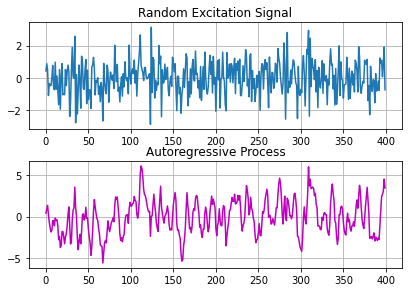

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
plt.tight_layout()
ax[0].plot(range(N), ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")
ax[1].plot(range(N), S, color='m')
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")

## Generating a Time-varying AR process

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Length of time series
#
N=400


In [35]:
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)


In [36]:
# Second order AR Process with coefficients slowly changing in time
#
a0 = np.array([1.2, -0.4])
A = np.zeros((N,2))
omega, alpha = N/2, 0.1

In [37]:
for n in range(N):
    A[n,0] = a0[0] + alpha * np.cos(2*np.pi*n/N)
    A[n,1] = a0[1] + alpha * np.sin(np.pi*n/N)

In [38]:
S = ex.copy();
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, A[n,:]) + ex[n]


Text(0.5, 1.0, 'Time Varying Autoregressive Process')

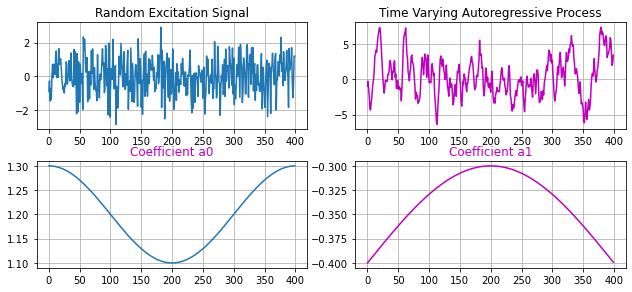

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()
ax[1,0].plot(range(N), A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0", color='m')
ax[1,1].plot(range(N), A[:,1], color='m')
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1", color='m')
ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")
ax[0,1].plot(range(N), S, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")

# Kalman Filter Estimates of second order AR parameters

In [40]:
# Time series data y
# th_n_n: estimate at time n using all data upto time n
# th_n_n1: estimate at time n using all data upto time n-1
#

In [41]:
# Initialize
#
x = np.zeros((2,1))
th_n1_n1 = np.array([[2],[0.5]])
P_n1_n1 = 0.001*np.eye(2)
v_n = np.random.randn(2,1)
y = th_n1_n1 * x + v_n

In [42]:
# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (first few samples)
# Guess for process noise
#
R = 0.5*np.std(ex[0:10])
beta = 0.01
Q = beta*np.eye(2)


In [43]:
# Space to store and plot
#
th_conv = np.zeros([2, N])

In [44]:
# First two estimates are initial guesses
#
th_conv[0,0] = th_n1_n1[0]
th_conv[0,1] = th_n1_n1[1]
th_conv[1,0] = th_n1_n1[0]
th_conv[1,1] = th_n1_n1[1]


In [45]:
# Kalman Iteration Loop (univariate observation, start from time step 2)
#
for n in range(2, N):
    # Input vector contains past values
    y = S
    ePlot = np.zeros(N)
    x[0] = y[n-1]
    x[1] = y[n-2]
    # Prediction of state and covariance
    th_n_n1 = th_n1_n1.copy()
    P_n_n1 = P_n1_n1 + Q
    yh = th_n_n1.T @ x
    en = y[n] - yh
    ePlot[n] = en
    # Kalman gain (kn) and innovation variance (den)
    #
    6
    den = x.T @ P_n1_n1 @ x + R
    kn = P_n1_n1 @ x / den
    # Posterior update
    #
    th_n_n = th_n_n1 + kn * en
    P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
    # Save
    th_conv[0,n] = th_n_n[0]
    th_conv[1,n] = th_n_n[1]
    # Remember for next step
    #
    th_n1_n1 = th_n_n.copy()
    P_n1_n1 = P_n_n.copy()
    
print(a)
print(th_n_n)


[ 1.2 -0.4]
[[ 1.38133424]
 [-0.30505548]]


Text(0.5, 1.0, 'Convergence 1')

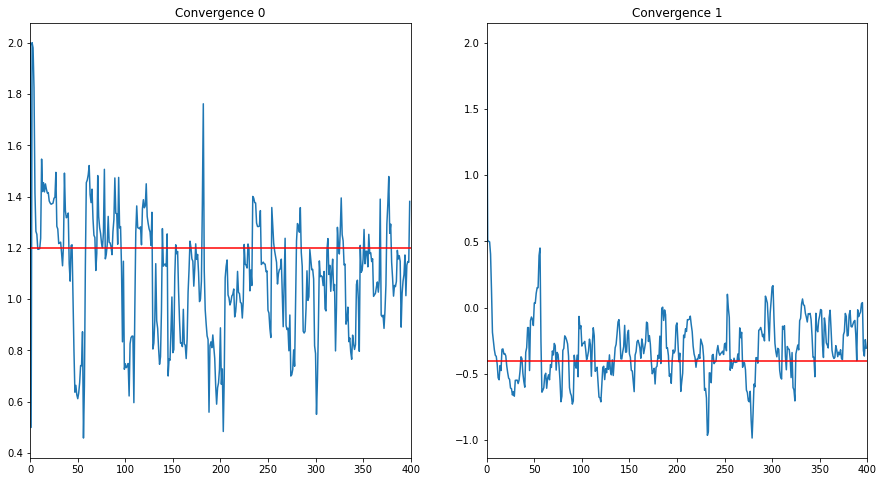

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax[0].plot(th_conv[0])
ax[0].set_xlim(0,N)
ax[0].axhline(y=a[0], color='r')
ax[0].set_title("Convergence 0")
ax[1].plot(th_conv[1])
ax[1].set_xlim(0,N)
ax[1].axhline(y=a[1], color='r')
ax[1].set_title("Convergence 1")


## Pycalman

In [47]:
from pykalman import KalmanFilter


In [48]:
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [49]:
# states = np.zeros((n_timesteps, n_dim_state))
# measurements = np.zeros((n_timesteps, n_dim_obs))
# for t in range(n_timesteps-1):
#     if t == 0:
#         states[t] = norm.rvs(initial_state_mean, np.sqrt(initial_state_covariance))
#         measurements[t] = (
#            np.dot(observation_matrices[t], states[t])
#            + observation_offsets[t]
#            + norm.rvs(0, np.sqrt(observation_covariance))
#       )
#     states[t+1] = (
#       np.dot(transition_matrices[t], states[t])
#       + transition_offsets[t]
#       + norm.rvs(0, np.sqrt(transition_covariance))
#    )
#     measurements[t+1] = (
#       np.dot(observation_matrices[t+1], states[t+1])
#       + observation_offsets[t+1]
#       + norm.rvs(np.sqrt(observation_covariance))
#   )

TypeError: 'AxesSubplot' object is not subscriptable

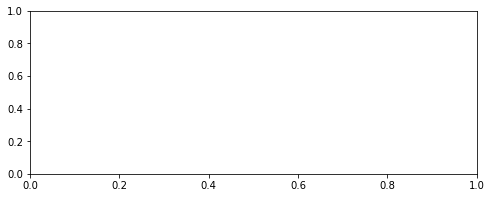

In [50]:
fig, ax = plt.subplots(figsize=(8,3))
ax[0].plot(kf.filter(measurements))
ax[0].set_xlim(0,500)
ax[0].axhline(color='r')
# ax[1].plot(th_conv[1])
# ax[1].set_xlim(0,500)
# ax[1].axhline(y=a[1], color='r')
# ax[1].set_title("R = %4.3f, Q = %6.5f I"%(R, beta))


In [ ]:
import numpy as np
import pylab as pl
from pykalman import KalmanFilter

# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
transition_covariance = np.eye(2)
observation_covariance = np.eye(2) + random_state.randn(2, 2) * 0.1
initial_state_mean = [5, -5]
initial_state_covariance = [[1, 0.1], [-0.1, 1]]

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
states, observations = kf.sample(
    n_timesteps=50,
    initial_state=initial_state_mean
)

# estimate state with filtering and smoothing
filtered_state_estimates = kf.filter(observations)[0]
smoothed_state_estimates = kf.smooth(observations)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_filt = pl.plot(filtered_state_estimates, color='r')
lines_smooth = pl.plot(smoothed_state_estimates, color='g')
pl.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()